# Human Rhinovirus Serotype

In [1]:
import os
import openpharmacophore as oph
import pyunitwizard as puw
from openpharmacophore.pharmacophore.align import align_pharmacophores

## Load and visualize protein-ligand complexes

In [2]:
pdbs_path = "../data/hrv/"

In [3]:
def load_proteins():
    

    prots = [
        oph.load(os.path.join(pdbs_path, "1c8m.pdb")),
        oph.load(os.path.join(pdbs_path, "1ncr.pdb")),
        oph.load(os.path.join(pdbs_path, "1nd3.pdb")),
    ]

    print(prots[0].ligand_ids())
    print(prots[1].ligand_ids())
    print(prots[2].ligand_ids())
    
    return prots

In [4]:
proteins = load_proteins()

['W11:E']
['MYR:F', 'W11:E']
['W11:E']


In [5]:
viewer = oph.Viewer()
viewer.add_components(proteins)
viewer.show()

NGLWidget()

In [7]:
viewer._show_html("../../../_static/hrv_1.html")

## Extracting ligands

We extract the ligands with code W11 that corresponds to pleconaril.

In [8]:
lig_id = proteins[0].ligand_ids()[0]
smiles = oph.smiles_from_pdb_id(lig_id)
smiles

'Cc1cc(cc(c1OCCCc2cc(no2)C)C)c3nc(on3)C(F)(F)F'

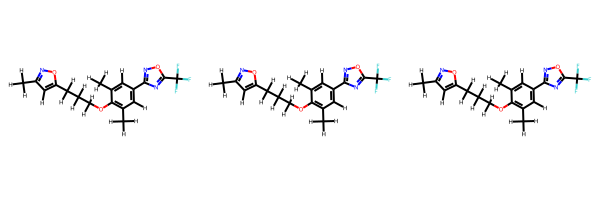

In [9]:
def load_ligands():

    lig_list = [p.get_ligand(lig_id) for p in proteins]
    for lig in lig_list:
        lig.fix_bond_order(smiles=smiles)
        lig.add_hydrogens()
        
    return lig_list

ligands = load_ligands()
oph.draw_ligands(ligands, n_per_row=3)

## Preparing proteins

In [10]:
for prot in proteins:
    prot.extract_chain("A")
    prot.add_hydrogens()
    assert not prot.has_ligands()
    assert not prot.has_solvent_or_ions()

In [11]:
viewer = oph.Viewer()
viewer.add_components(proteins + ligands)
viewer.show()

NGLWidget()

In [12]:
viewer._show_html("../../../_static/hrv_2.html")

## Obtaining binding sites

In [13]:
binding_sites = []

for ii in range(len(proteins)):
    binding_sites.append(oph.ComplexBindingSite(proteins[ii], ligands[ii]))

## Extracting pharmacophores

In [14]:
pharmacophores = []

for ii in range(len(binding_sites)):
    lrp = oph.LigandReceptorPharmacophore(binding_sites[ii], ligands[ii])
    lrp.extract()
    print(f"\nPharmacophore {ii + 1}")
    for pnt in lrp[0]:
        print(pnt)
        
    pharmacophores.append(lrp)


Pharmacophore 1
PharmacophoricPoint(feat_type=hydrophobicity; center=(48.89, -4.4, 121.79); radius=1.0)
PharmacophoricPoint(feat_type=hydrophobicity; center=(40.93, 3.43, 122.23); radius=1.0)
PharmacophoricPoint(feat_type=hydrophobicity; center=(45.04, 3.15, 123.78); radius=1.0)
PharmacophoricPoint(feat_type=hydrophobicity; center=(41.87, -0.79, 122.69); radius=1.0)

Pharmacophore 2
PharmacophoricPoint(feat_type=aromatic ring; center=(38.03, 4.36, 123.74); radius=1.0; direction=(-0.67, -0.05, -0.74))
PharmacophoricPoint(feat_type=hydrophobicity; center=(49.65, -4.36, 122.0); radius=1.0)
PharmacophoricPoint(feat_type=hydrophobicity; center=(41.14, 2.96, 122.61); radius=1.0)
PharmacophoricPoint(feat_type=hydrophobicity; center=(45.46, 2.01, 123.42); radius=1.0)
PharmacophoricPoint(feat_type=hydrophobicity; center=(41.37, -1.11, 122.68); radius=1.0)

Pharmacophore 3
PharmacophoricPoint(feat_type=aromatic ring; center=(37.82, 4.36, 123.82); radius=1.0; direction=(-0.64, -0.06, -0.77))
Pha

In [17]:
idx = 2
viewer = oph.Viewer()
viewer.add_components([
    proteins[idx],
    ligands[idx],
    pharmacophores[idx],
])
viewer.show()

NGLWidget()

<img src="../../../_static/hrv_1.png">

## Finding a common pharmacophore

To find a common pharmacophore we align the pharmacophores with one another. We'll choose the one with lowest rmsd as the 
consensus pharmacophore

In [19]:
pharma_mat = [
    puw.get_value(p[0].to_matrix()) for p in pharmacophores
]


hydrophobics = [
    pharma_mat[0], pharma_mat[1][1:, :], pharma_mat[2][1:, :]
]

Align hydrophobic features

In [20]:
def align_and_score(matrices):
    
    rmsd_list = []
    for ii in range(len(matrices)):
        avg_rmsd = 0
        for jj in range(len(matrices)):
            if ii == jj:
                continue
            rmsd, _ = align_pharmacophores(matrices[ii], matrices[jj]) 
            avg_rmsd += rmsd 
            
        avg_rmsd /= (len(matrices) - 1)
        rmsd_list.append(avg_rmsd)
    
    return rmsd_list


In [21]:
rmsd_list = align_and_score(hydrophobics)
rmsd_list

[0.671464357705515, 0.3367555679305882, 0.33734245356241305]

Taking the second pharmacophore as the alignment reference gives the lowest RMSD.
So we take this as our common pharmacophore

In [22]:
viewer = oph.Viewer()
viewer.add_components(ligands + [pharmacophores[2]])
viewer.show()

NGLWidget()

<img src="../../../_static/hrv_2.png">

Align hydrophobic features and aromatic ring

In [25]:
rmsd_list = align_and_score(pharma_mat[1:])
rmsd_list

[0.0025020000021948063, 0.0025020000021948063]

In [26]:
viewer = oph.Viewer()
viewer.add_components(ligands + [pharmacophores[1]])
viewer.show()

NGLWidget()

<img src="../../../_static/hrv_3.png">

In [29]:
# Save pharmacophore image so it can be viewed in the documentation
 
import time
import threading

save = False

def save_image(view):
    im = view.render_image()
    while not im.value:
        time.sleep(0.1)
    save_path = "../../../_static/hrv_3.png"
    with open(save_path, "wb") as fp:
        fp.write(im.value)    

def generate_image():
    thread = threading.Thread(target=save_image, args=(viewer.to_nglview(),), daemon=True)
    thread.start()
    

if save:
    generate_image()